In [8]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.miscellaneous import moving_average

In [9]:
# Define and example command for Cartpole v0
env = gym.make('CartPole-v1')
state1 = env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)


In [25]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards   
    disc_return /= disc_return.max() #Normalizes to 0,1
    return disc_return

def loss_fn(preds, r):
    return -1 * torch.sum(r * torch.log(preds))  # sum of action probability times reward


In [31]:
# Define the network
l1 = env.observation_space.shape[0]
l2 = 150 # Hidden layer
l3 = 2
l1 = 4

model = torch.nn.Sequential(
torch.nn.Linear(l1, l2),
torch.nn.LeakyReLU(),
torch.nn.Linear(l2, l3),
torch.nn.Softmax()
)

learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
Max_duration = 200
Max_episod = 2000
gamma = 0.9
score = []
for ep in tqdm(range(Max_episod)):
    state1 = env.reset()
    done = False 
    transitions = [] # list of state, action, reward
    for t in range(Max_duration):
        action_prob = model(torch.from_numpy(state1).float())
        action = np.random.choice(np.array([0, 1]), p=action_prob.data.numpy())
        state0 = state1.copy()
        state1 , _, done, info = env.step(action)
        transitions.append((state0, action, t+1))
        if done:
            break
        
    ep_len = len(transitions)
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,))
    disc_reward = discount_rewards(reward_batch)
    state_batch = torch.Tensor([s for (s,a,r) in transitions])
    action_batch = torch.Tensor([a for (s,a,r) in transitions])
    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze() # action prob associated with actual taken actions
    loss = loss_fn(prob_batch, disc_reward)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]/home/mehrdad/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 2000/2000 [00:36<00:00, 55.35it/s]


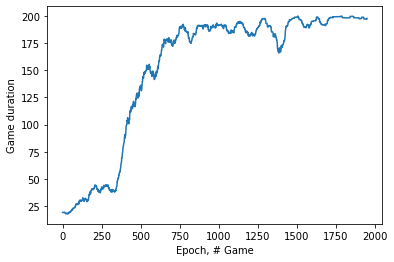

In [32]:
plt.plot(moving_average(score, w = 50))
plt.xlabel("Epoch, # Game")
plt.ylabel("Game duration")
plt.show()